<a href="https://colab.research.google.com/github/Shritej24c/NLP101/blob/main/HW/HW6/ShritejShrikant_Chavan_HW6d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

## Setup Environment and Install Libraries

In [15]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate seqeval -U -qq
    !pip install datasets transformers[sentencepiece] evaluate wandb accelerate -U -qq
    !pip install sacrebleu bert_score -U -qq
    base_folder = Path("/content/drive/MyDrive/NLP")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")



from transformers import AutoConfig, AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, pipeline
from datasets import load_dataset, DatasetDict
import evaluate
from evaluate import evaluator

from transformers import GenerationConfig


from datasets import load_dataset, DatasetDict, Dataset, ClassLabel, Sequence
import evaluate


import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gc

import textwrap



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00


## Specify Model & Data Path

In [16]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/brown_corpus'
model_folder = base_folder/'models/nlp_spring_2023/kde4'
model_folder.mkdir(exist_ok=True)
data_folder.mkdir(exist_ok=True)

## Create Functions

In [17]:
def print_wrap(text, d):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)


### Load and Split Dataset

In [18]:
def split_dataset(data = 'kde4', train = 1000, val_test = 500):
    kde_dataset = load_dataset('kde4', lang1='en', lang2='fr')

    test_val_splits = kde_dataset['train'].train_test_split(test_size=0.4, seed=42)
    train_split= test_val_splits['train']
    test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
    val_split = test_val_splits['train']
    test_split = test_val_splits['test']



    train_split_small = train_split.shuffle(seed=42).select(range(train))
    val_split_small = val_split.shuffle(seed=42).select(range(val_test))
    test_split_small = test_split.shuffle(seed=42).select(range(val_test))

    # combine train, val splits into one dataset
    train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

    # create test dataset from test split
    test_subset = DatasetDict({'test': test_split_small})


    return train_val_subset, test_subset



###  <font color = 'indianred'> **Create function for Tokenizer**

### Function for Tokenization

In [19]:
def get_tokenized_dataset(checkpoint, dataset):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)


    max_length = 128
    def tokenize_fn(batch):
        inputs = [example['en'] for example in batch['translation']]
        targets = [example['fr'] for example in batch['translation']]
        model_inputs = tokenizer(text = inputs, text_target=targets, truncation = True, max_length=max_length)
        return model_inputs
        # CODE HERE

    tokenized_dataset = dataset.map(tokenize_fn, batched=True)

    tokenized_dataset = tokenized_dataset.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])

    tokenized_dataset.set_format(type='torch')

    return tokenized_dataset

### Function to initialize model

In [20]:
def initialize_model(checkpoint):

    config = AutoConfig.from_pretrained(checkpoint)

    generation_config = GenerationConfig.from_pretrained(checkpoint)

    model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint,
    config=config,
    )

    return model, config

### Function to compute metrics

In [21]:
bleu_metric = evaluate.load("sacrebleu")
bert_metric = evaluate.load('bertscore')

def compute_metrics(preds_and_labels):
    # preds are not logits but token ids
    # api is inconsistent here
    # we are not simply using argmax bu use 'beam search'
    preds, labels = preds_and_labels

    # convert predictions into words
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # for any -100 label, replace with pad token id
    labels = np.where( labels != -100, labels, tokenizer.pad_token_id )

    # convert labels into words
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens= True)

    # get rid of extra whitespace
    # and also, put targets into lists

    decoded_preds_cleaned = [pred.strip() for pred in decoded_preds]
    decoded_labels_cleaned = [label.strip() for label in decoded_labels]

    bleu_score = bleu_metric.compute(predictions=decoded_preds_cleaned, references=decoded_labels_cleaned)
    bert_score = bert_metric.compute(predictions=decoded_preds_cleaned, references=decoded_labels_cleaned, lang='fr')

    return{'bleu_score:': bleu_score['score'], 'bert_score': np.mean(bert_score['f1'])}
    # CODE HERE



### Function to set Trainer

In [22]:
def get_trainer(model, training_args, train_dataset, eval_dataset, compute_metrics, tokenizer, data_collator):
    trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    )
    return trainer

### Plot Confusion Matrix

In [23]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

### Function to tokenize dataset and, train and eval models

In [32]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder, train_val_subset, compute_metrics):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_course_fall_2023-HW6-PartD

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder / "models" / "nlp_spring_2023/ner"/checkpoint
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_subset)

    # 4. Initialize Model and Tokenizer
    model, config = initialize_model(checkpoint)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    )

    trainer = get_trainer(model, training_args, train_val_tokenized_dataset['train'],
                          train_val_tokenized_dataset['val'], compute_metrics, tokenizer, data_collator)

    # 6. Train and Evaluate
    trainer.train()
    trainer.evaluate(train_val_tokenized_dataset['val'])


    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

## Experiments

### Experiment 1 - BERT base uncased

In [27]:
from transformers import Seq2SeqTrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models" / "nlp_spring_2023/kde4/opus-mt-en-fr"

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

checkpoint = 'Helsinki-NLP/opus-mt-en-fr'
generation_config = GenerationConfig.from_pretrained(checkpoint)


# Configure training parameters
training_args = Seq2SeqTrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim="adamw_torch",  # Optimizer,
    warmup_steps=10,
    predict_with_generate=True,
    generation_config=generation_config,
    # memory and speed related arguments
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,  # Number of samples per eval batch for each device

    gradient_checkpointing=True,  # memory
    # fp16 = True, # Speed
    # bf16=True,
    # tf32=True, # speed
    # evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy="steps",  # Evaluate model at specified step intervals
    eval_steps=10,  # Perform evaluation every 10 training steps
    # Checkpoint settings
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=10,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # metric_for_best_model=,
    # greater_is_better=,
    # Experiment logging configurations (commented out in this example)
    logging_strategy="steps",
    logging_steps=10,
    report_to="wandb",  # Log metrics and results to Weights & Biases platform
    # Experiment name for Weights & Biases
    run_name="translation-exp1",
)


In [28]:
train_val_subset, test_subset = split_dataset()



Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

In [30]:
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}' # Update the run_name
new_training_args = Seq2SeqTrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1697: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


In [33]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-HW6-PartD


ValueError: ignored

### Experiment 2 - Changing Subset of the training Data from 5k to 10k and val & test from 1k to 2k

In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_spring_2023/ner"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

In [ ]:
train_val_subset, test_subset, class_names = split_dataset(train = 10000, val_test = 2000)


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
checkpoint = 'distilbert-base-uncased' # CODE HERE
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1697: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-HW6-PartC


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: Currently logged in as: shritej24c (redeem_team). Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.277200,0.864311,0.000000,0.000000,0.000000,0.789764
40,0.700500,0.555754,0.109375,0.005705,0.010844,0.797880
60,0.462200,0.408923,0.495408,0.498234,0.496817,0.876937
80,0.308700,0.312520,0.527083,0.589514,0.556553,0.921204
100,0.311500,0.246012,0.599159,0.658245,0.627314,0.933220
120,0.238200,0.205225,0.668611,0.716381,0.691672,0.943141
140,0.238500,0.175622,0.731862,0.783754,0.756920,0.953691
160,0.183700,0.153185,0.773619,0.803043,0.788057,0.959503
180,0.168200,0.155495,0.743722,0.820701,0.780318,0.956597
200,0.175100,0.139899,0.773327,0.828579,0.800000,0.961178


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

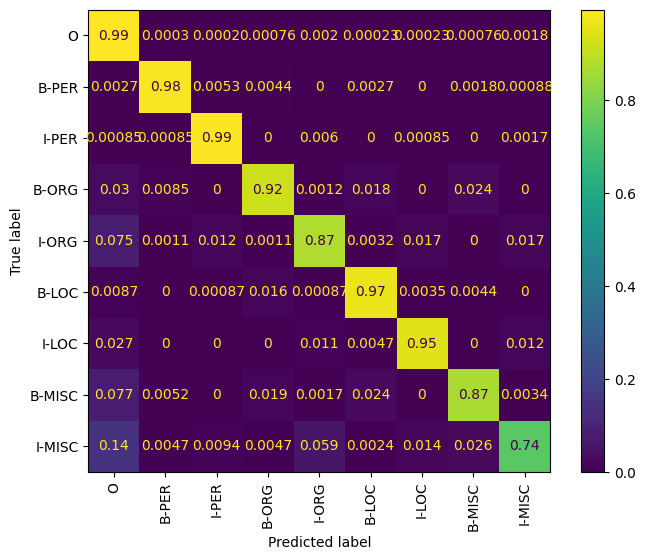

The best model was saved at step 1220.


eval/accuracy,▁▁▆▆▇▇▇▇████████████████████████████████
eval/f1,▁▁▅▆▇▇▇▇▇▇██████████████████████████████
eval/loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▅▆▇▇▇▇▇▇▇███▇▇████████████████████████
eval/recall,▁▁▅▆▇▇▇▇█▇██████████████████████████████
eval/runtime,▁▂▂▂▁▂▂▁▂▂▂▂▃▆▂▄▃▃▁▂▁▁▂▁▁▃▁▁▂▂▂▃▁▁▂▁▂▁▂█
eval/samples_per_second,█▇▇▇█▇▇█▆▇▇▇▆▂▇▅▆▅█▆██▇██▆▇█▆▇▇▆██▇▇▇█▇▁
eval/steps_per_second,█▇▇▇█▇▇█▆▇▇▇▆▂▇▅▆▅█▆██▇██▆▇█▆▇▇▆██▇▇▇█▇▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)